In [31]:
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm import tqdm
from multiprocessing import Pool

### Read user info

In [2]:
with open('user_info.json') as f:
    user_info = json.load(f)

In [3]:
user_info[0]

{'record': '02425',
 'gender': 0,
 'age': 67,
 'bsa': 1.78,
 'bmi': 23.18,
 'smoker': 1,
 'sbp': 120.0,
 'dbp': 80.0,
 'vascular_event': 0,
 'hypertensive': 1}

### Read IHR data

In [4]:
ihr_data = []
for uinfo in tqdm(user_info):
    with open(f'files/ihr_data/{uinfo["record"]}.txt') as f:
        ihr_data.append([float(x.strip()) for x in f])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:04<00:00, 43.63it/s]


In [5]:
max_len = len(max(ihr_data, key=len))
for i in tqdm(range(len(ihr_data))):
    ihr_data[i] = ihr_data[i] + [0] * (max_len - len(ihr_data[i]))
ihr_data = np.array(ihr_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 801.95it/s]


## With original IHR data

### PCA

In [42]:
pca = PCA(2)
ihr_data_reduced = pca.fit_transform(ihr_data)

### K-Means

In [43]:
kmeans = KMeans(n_clusters=2)
label = kmeans.fit_predict(ihr_data_reduced)

### Plot

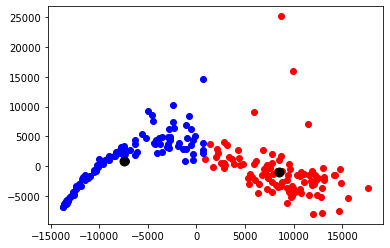

In [46]:
centroids = kmeans.cluster_centers_
cluster1 = ihr_data_reduced[label == 0] 
cluster2 = ihr_data_reduced[label == 1]

plt.scatter(cluster1[:,0] , cluster1[:,1] , color='red')
plt.scatter(cluster2[:,0] , cluster2[:,1] , color='blue')
plt.scatter(centroids[:,0] , centroids[:,1] , s=80, color='k')

plt.show()

## With 17M samples

### Load samples in memory

In [35]:
with h5py.File('128_overlap/physiobank_dataset.hdf5', 'r') as f:
    key_list = list(f.keys())[:60]
    stride = len(key_list) // 6
    key_list = [key_list[x:x+stride] for x in range(0, len(key_list), stride)]

In [33]:
def load_data(keys):
    accumulator = None
    ihr_seq_file = h5py.File('128_overlap/physiobank_dataset.hdf5', 'r')
    for key in keys:
        key_data = np.expand_dims(ihr_seq_file[key][:], axis=0)
        accumulator = key_data if accumulator is None else np.concatenate((accumulator, key_data), axis=0)
    ihr_seq_file.close()
    return accumulator

In [38]:
accumulator = None
pool = Pool(6)
for idx, accumulated_data in tqdm(enumerate(pool.imap_unordered(load_data, key_list))):
    accumulator = accumulated_data if accumulator is None else np.concatenate((accumulator, accumulated_data), axis=0)

6it [00:00, 256.04it/s]


### PCA

In [39]:
pca = PCA(2)
ihr_reduced_data = pca.fit_transform(accumulator)

### K-Means

In [40]:
kmeans = KMeans(n_clusters=2)
label = kmeans.fit_predict(ihr_reduced_data)

### Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


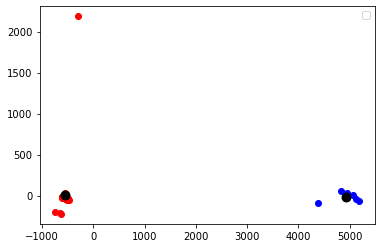

In [41]:
centroids = kmeans.cluster_centers_
cluster1 = ihr_reduced_data[label == 0] 
cluster2 = ihr_reduced_data[label == 1]

plt.scatter(cluster1[:,0] , cluster1[:,1] , color='red')
plt.scatter(cluster2[:,0] , cluster2[:,1] , color='blue')
plt.scatter(centroids[:,0] , centroids[:,1] , s=80, color='k')

plt.legend()
plt.show()